In [508]:
import torch, fastai
from fastai.collab import *
from fastai.tabular import *

# set the environment path to find Recommenders
import sys
sys.path.append("../../")
import time
import os
import itertools
import pandas as pd
import papermill as pm

from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_random_split
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Fast AI version: {}".format(fastai.__version__))
print("Torch version: {}".format(torch.__version__))
print("Cuda Available: {}".format(torch.cuda.is_available()))
print("CuDNN Enabled: {}".format(torch.backends.cudnn.enabled))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4
Fast AI version: 1.0.39
Torch version: 1.0.0
Cuda Available: True
CuDNN Enabled: True


In [509]:
USER,ITEM,RATING,TIMESTAMP,PREDICTION,TITLE = 'UserId','MovieId','Rating','Timestamp','Prediction','Title'

In [510]:
# top k items to recommend
TOP_K = 10

# Select Movielens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

In [511]:
ratings_df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=[USER,ITEM,RATING,TIMESTAMP]
)

ratings_df.head()

# make sure the IDs are loaded as strings to better prevent confusion with embedding ids
ratings_df[USER] = ratings_df[USER].astype('str')
ratings_df[ITEM] = ratings_df[ITEM].astype('str')

In [512]:
# this step is optional and it will currently only work with 100k

# it is much easier to make sense of the results when working with movie titles than IDs
# load the movie titles and join them with the ratings 
## this would need to be moved to/merged in with dataset/movielens.py

movies = pd.read_csv('u.item',  delimiter='|', encoding='latin-1', header=None, dtype={ITEM:'str'},
                    names=[ITEM, TITLE, *[f'f{i}' for i in range(22)]])
movies = movies[[ITEM, TITLE]]
ratings_df = ratings_df.merge(movies)

# now make the title column the ITEM, so it will propagate throughout the model
ITEM = TITLE

## Training

In [513]:
data = CollabDataBunch.from_df(ratings_df, pct_val=0.25, user_name=USER, item_name=ITEM, rating_name=RATING)

In [514]:
data.show_batch()

UserId,Title,target
354,"Day the Earth Stood Still, The (1951)",3.0
619,"Crow, The (1994)",3.0
592,Spawn (1997),1.0
733,Dead Man (1995),3.0
374,"Sound of Music, The (1965)",2.0


In [515]:
y_range = [0,5.5]

In [516]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


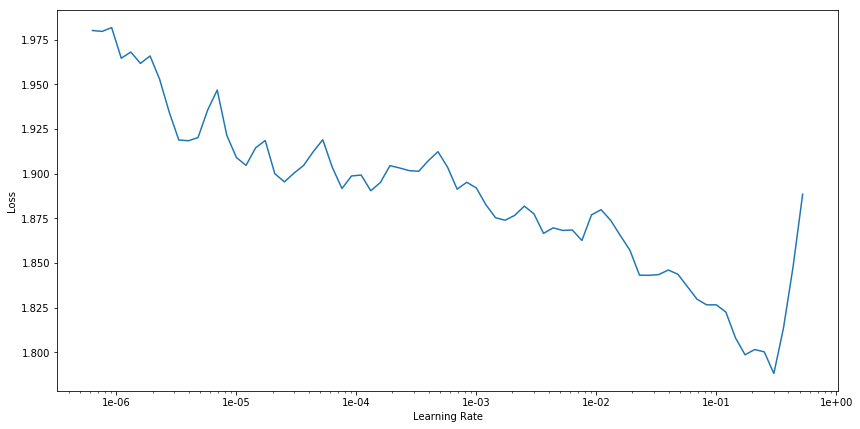

In [517]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [518]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.963594,0.935807
2,0.885761,0.868776
3,0.771503,0.825219
4,0.659502,0.807895
5,0.538698,0.806676


In [519]:
learn.save('fastai-model')

## Generating Recommendations

In [520]:
model = learn.model

In [521]:
def recommend(learner, user):
    """score all items for the user"""
    data = learner.data
    userIds, movieIds = data.classes.values()
    movieIds = movieIds[1:] # drop the first element (#na#)
    m = learner.get_idx(movieIds, is_item=True)
    u = learner.get_idx([user for i in range(movieIds.size)], is_item=False)
    
    pred = learner.model.forward(u, m)
    scores = pd.DataFrame({ITEM:movieIds, PREDICTION:pred})
    return scores.sort_values(PREDICTION,ascending=False)

def compare_recommendation(learner, user, rating_movie, user_col, item_col, rating_col):
    """compare the recommendation to what the user viewed"""
    movies = learner.data.classes[item_col]
    recommended = recommend(learn, user)
    user_ratings = rating_movie[rating_movie[user_col].astype('str')==user]
    return recommended.merge(how='left', on=item_col, right=user_ratings[[item_col,rating_col]])

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)  

def score(learner, userIds, movieIds, user_col, item_col, prediction_col, top_k=0):
    """score all items for the user"""
    u = learner.get_idx(userIds, is_item=False)
    m = learner.get_idx(movieIds, is_item=True)
    
    pred = learner.model.forward(u, m)
    scores = pd.DataFrame({user_col: userIds, item_col:movieIds, prediction_col:pred})
    scores =  scores.sort_values([user_col,prediction_col],ascending=[True,False])
    if top_k > 0:
        top_scores = scores.groupby(user_col).head(top_k).reset_index(drop=True)
    else:
        top_scores = scores
    return top_scores

In [522]:
# get the validation and test sets from the learner
valid_df = pd.DataFrame({USER:[row.classes[USER][row.cats[0]] for row in learn.data.valid_ds.x], 
                        ITEM:[row.classes[ITEM][row.cats[1]] for row in learn.data.valid_ds.x], 
                        RATING: [row.obj for row in data.valid_ds.y]})

train_df = pd.DataFrame({USER:[row.classes[USER][row.cats[0]] for row in learn.data.train_ds.x], 
                        ITEM:[row.classes[ITEM][row.cats[1]] for row in learn.data.train_ds.x], 
                        RATING: [row.obj for row in data.train_ds.y]})


# get all users from validation set
valid_users = valid_df[USER].unique()

# get all items
_, total_items = data.classes.values()
total_items = np.array(total_items[1:])

# build the cross product to score all items for all users
users_items = cartesian_product(np.array(valid_users),np.array(total_items))
users_items = pd.DataFrame(users_items, columns=[USER,ITEM])

# now remove the ones that the user already rated per the training set
training_removed = pd.concat([users_items, train_df[[USER,ITEM]], train_df[[USER,ITEM]]]).drop_duplicates(keep=False)

### Score the model -- find top K recommendation

In [523]:
top_k_scores = score(learn, training_removed[USER], training_removed[ITEM], 
                     user_col=USER, item_col=ITEM, prediction_col=PREDICTION, top_k=TOP_K)

### calculate the metrics as done for SAR

In [524]:
eval_map = map_at_k(valid_df, top_k_scores, col_user=USER, col_item=ITEM, 
                    col_rating=RATING, col_prediction=PREDICTION, 
                    relevancy_method="top_k", k=TOP_K)

In [525]:
eval_ndcg = ndcg_at_k(valid_df, top_k_scores, col_user=USER, col_item=ITEM, 
                      col_rating=RATING, col_prediction=PREDICTION, 
                      relevancy_method="top_k", k=TOP_K)

In [526]:
eval_precision = precision_at_k(valid_df, top_k_scores, col_user=USER, col_item=ITEM, 
                                col_rating=RATING, col_prediction=PREDICTION, 
                                relevancy_method="top_k", k=TOP_K)

In [527]:
eval_recall = recall_at_k(valid_df, top_k_scores, col_user=USER, col_item=ITEM, 
                          col_rating=RATING, col_prediction=PREDICTION, 
                          relevancy_method="top_k", k=TOP_K)

In [528]:
print("Model:\t" + learn.__class__.__name__,
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Model:	CollabLearner
Top K:	10
MAP:	0.025300
NDCG:	0.153071
Precision@K:	0.136373
Recall@K:	0.053564


The above numbers seem low (compared to SAR) -- so checking whether the model makes sensible predictions. Look at individual users in the validation set and how the model predicts how they would rate movies.

In [529]:
scores = score(learn, training_removed[USER], training_removed[ITEM], 
               user_col=USER, item_col=ITEM, prediction_col=PREDICTION)

validation_with_prediction = valid_df.merge(scores, on=[USER,ITEM], how='left').dropna()

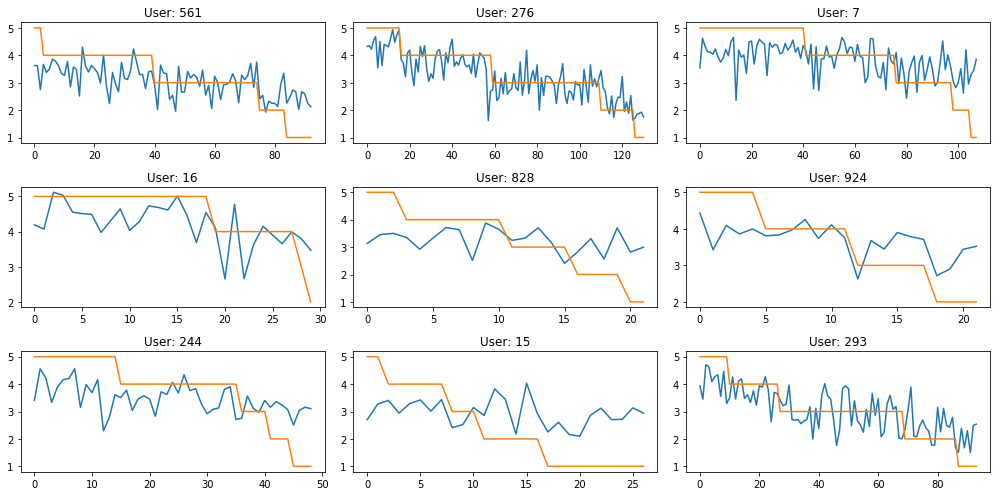

In [530]:
def plot_random_user(subplot):
    random_user = np.random.choice(validation_with_prediction[USER])

    one_user = validation_with_prediction[validation_with_prediction[USER]==random_user].copy()
    one_user = one_user.sort_values(RATING, ascending=False)

    plt.subplot(subplot)
    plt.plot(range(len(one_user)), one_user[PREDICTION])
    plt.plot(range(len(one_user)), one_user[RATING])
    plt.title('User: ' + random_user)

plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(1)

for subplot in range(331,340):
    plot_random_user(subplot)

plt.tight_layout()
plt.show()

In [531]:
# Mean Squared Error
mse = np.mean(np.square(validation_with_prediction[PREDICTION]-validation_with_prediction[RATING]))
mse

0.8076758614977997

In [532]:
rmse = math.sqrt(mse)
rmse

0.8987078844083876

That RMSE is actually quite decent when compared to these benchmarks: https://www.librec.net/release/v1.3/example.html